In [1]:
import numpy as np
import sys,shutil
from scipy import linalg
import scipy.special as sysp

sys.path.append('../code/')
from sbi import NeuralRatioEstimator

import copy,pickle
from time import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

# cobaya imports
from cobaya.run import run
from cobaya.log import LoggedError
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of NeuralRatioEstimator
### simple NRE using Sequential NN tested on (non-)linear Gaussian problems

## Simulator setup

In [ ]:
nparam = 6
ndata = 25

File_Stem = 'gaussmix' # 'poly','gaussmix'
Plots_Dir = File_Stem + '/plots/'

class MyNRE(NeuralRatioEstimator):
    def __init__(self,params={}):
        NeuralRatioEstimator.__init__(self,params=params)

        if self.file_stem == 'gaussmix':
            if (self.nparam % 3) != 0:
                raise ValueError("param_dim must be multiple of 3")
            self.ncomp = self.nparam // 3
        
        # data variables and noise
        self.xvals = np.linspace(-1.5,3.5,self.ndata)
        self.sigma = np.linspace(0.1,0.5,self.ndata)
        self.cov_mat = np.diagflat(self.sigma**2)

        # prior mean,std
        self.prior_mean = np.zeros(self.nparam)
        self.prior_std = 6*np.ones(self.nparam)

        # # prior bounds
        # self.theta_min = -10*np.ones(self.nparam)
        # self.theta_max = 10*np.ones(self.nparam)
        # self.dtheta = self.theta_max - self.theta_min        
        
        return
    
    def simulator(self,theta):
        out = np.zeros((self.ndata,theta.shape[1]))
        if self.file_stem == 'poly':
            ####################
            # polynomial
            out += np.sum(np.array([np.outer(self.xvals**p,theta[p]) for p in range(self.nparam)]),axis=0)
            # for x in range(self.xvals.size):
            #     out[x] = np.sum([theta[p]*self.xvals[x]**p for p in range(self.nparam)])
            ####################
        else:
            for c in range(self.ncomp):
                amp = theta[c*3]
                mu = theta[c*3+1]
                mu = np.outer(np.ones(self.ndata),mu)
                lnsig2 = theta[c*3+2]
                # amp,mu,lnsig2 = theta[c*3:(c+1)*3,:]
                out += amp*np.exp(-0.5*(self.xvals-mu.T).T**2/np.exp(lnsig2))

        noise = self.rng.multivariate_normal(np.zeros(self.ndata),self.cov_mat,size=out.shape[1]) # shape (out.shape[1],out.shape[0])
        out += noise.T
        
        return out

    def prior(self,nsamp):
        theta = np.zeros((self.nparam,nsamp))
        
        for p in range(self.nparam):
            theta[p] = self.prior_mean[p] + self.rng.randn(nsamp)*self.prior_std[p]
            
        # for p in range(self.nparam):
        #     theta[p] = self.theta_min[p] + self.rng.rand(nsamp)*self.dtheta[p]
        
        return theta

## NRE setup and training

In [ ]:
Train = False

NReal = 3

L1 = 1 # 1 # number of layers with first activation
AType1 = 'tanh' # 'tanh'
NNodes1 = 10 # 50
L2 = 1 # 1 # number of layers with second activation
AType2 = 'tanh' # 'tanh'
NNodes2 = 10 # 100
L3 = 0 # 1 # number of layers with third activation
AType3 = 'tanh' # 'tanh'
NNodes3 = 0 # 20

Standardize = True
Weight_Decay = 0.0 # 0.0
LReLU_Slope = 1e-2 # 1e-2

start_time = time()
if Train:
    params = {'param_dim':nparam,'data_dim':ndata,'standardize':Standardize,'lrelu_slope':LReLU_Slope,
              'Lh':L1+L2+L3,'n_hidden_layer':[NNodes1]*L1+[NNodes2]*L2+[NNodes3]*L3,'hidden_atypes':[AType1]*L1+[AType2]*L2+[AType3]*L3,
              'wt_decay':Weight_Decay,'file_stem':File_Stem,'nreal':NReal}
    
    nre = MyNRE(params=params)
    NSamp = 320 # 640000
    ValFrac = 0.2
    params_train = {'max_epoch':1600, # 16000
                    'lrate':3e-3, # 3e-5
                    'check_after':100, # 1000
                    'mb_count':int(np.sqrt((1-ValFrac)*NSamp)),'val_frac':ValFrac}
    nre.train(NSamp,params=params_train)
    nre.save()
    nre.save_train(params_train)
else:
    with open(File_Stem + '/params.pkl', 'rb') as f:
        params = pickle.load(f)  
    nre = MyNRE(params=params)
    nre.load()
    params_train = nre.load_train()
    for r in range(1,NReal+1):
        nre.net[r].load_loss_history()
    
print('params_train:',params_train)
nre.time_this(start_time)

In [ ]:
print('min val loss...')
plt.yscale('log')
for r in range(1,NReal+1):
    min_val_loss = nre.net[r].val_loss[nre.net[r].val_loss > 0.0].min()
    print('... r{0:d} = {1:.3e}'.format(r,min_val_loss))
    plt.plot(nre.net[r].epochs,nre.net[r].training_loss,'k-',lw=0.5)
    plt.plot(nre.net[r].epochs,nre.net[r].val_loss,'r-',lw=0.5)
plt.show()

# OLD RESULTS USING ANALYTICAL COMPARISON & SINGLE REALISATION

## Simulator setup

In [238]:
nparam = 2
ndata = 15

Tight_Prior = True

File_Stem = 'line' # 'line','line-tight'
if Tight_Prior:
    File_Stem += '-tight'
Plots_Dir = File_Stem + '/plots/'

class MyNRE(NeuralRatioEstimator):
    def __init__(self,params={}):
        NeuralRatioEstimator.__init__(self,params=params)

        # data variables and noise
        self.xvals = np.linspace(-1,2,ndata)
        self.sigma = np.linspace(0.1,0.5,ndata)
        self.cov_mat = np.diagflat(self.sigma**2)

        # prior mean,std
        if Tight_Prior:
            self.prior_mean = np.array([1.0,-1.0])
            self.prior_std = np.array([5.0,5.0])
        else:
            self.prior_mean = np.array([0.0,0.0])
            self.prior_std = np.array([20.0,20.0])
        
        # # prior bounds
        # if Tight_Prior:
        #     self.theta_min = np.array([-4.0,-2.0])
        #     self.theta_max = np.array([4.0,2.0])
        # else:
        #     self.theta_min = np.array([-10.0,-3.0])
        #     self.theta_max = np.array([10.0,3.0])
        # self.dtheta = self.theta_max - self.theta_min        

        return
    
    def simulator(self,theta):
        out = np.zeros((self.xvals.size,theta.shape[1]))
        ####################
        # straight line
        for x in range(self.xvals.size):
            out[x] = theta[0] + theta[1]*self.xvals[x]
        ####################

        noise = self.rng.multivariate_normal(np.zeros(self.xvals.size),self.cov_mat,size=out.shape[1]) # shape (out.shape[1],out.shape[0])
        out += noise.T
        
        return out

    def prior(self,nsamp):
        theta = np.zeros((2,nsamp))

        # for p in range(theta.shape[0]):
        #     theta[p] = self.theta_min[p] + self.rng.rand(nsamp)*self.dtheta[p]
        
        for p in range(theta.shape[0]):
            theta[p] = self.prior_mean[p] + self.rng.randn(nsamp)*self.prior_std[p]
            
        return theta

## Analytical ratio for linear Gaussian problem
#### with design matrix $\mathcal{M}$, data $y$, data covariance $C$, prior inverse covariance $F_{\rm (p)}$, prior mean $\theta_{\rm (p)}$, we have
#### $F = \mathcal{M}^{\rm T}C^{-1}\mathcal{M} + F_{\rm (p)}$
#### $\hat\theta = F^{-1}\left(\mathcal{M}^{\rm T}C^{-1}y + F_{\rm (p)}\theta_{\rm (p)}\right)$
#### $-2\ln p(\theta|x) = (\theta-\hat\theta)^{\rm T}\,F\,(\theta-\hat\theta) - \ln{\rm det}F + M\ln(2\pi)$
#### $-2\ln p(\theta) = (\theta-\theta_{\rm (p)})^{\rm T}\,F_{\rm (p)}\,(\theta-\theta_{\rm (p)}) - \ln{\rm det}F_{\rm (p)} + M\ln(2\pi)$
#### $2\ln r(y,\theta) = 2\ln\left[p(\theta|y)/p(\theta)\right] = (\mathcal{M}\theta)^{\rm T}C^{-1}(y-\mathcal{M}\theta) + \left(\mathcal{M}(\theta-\hat\theta)\right)^{\rm T}C^{-1}y - (\hat\theta-\theta_{\rm (p)})^{\rm T}F_{\rm (p)}\theta_{\rm (p)} + \ln\,{\rm det}(FF_{\rm (p)}^{-1})$

In [4]:
def analytical_nre(nre,X,theta):
    designM = np.ones((nre.ndata,nre.nparam))
    for p in range(nre.nparam):
        designM[:,p] = nre.xvals**p # monomial basis
    F_p = np.diagflat(1/nre.prior_std**2) # prior inv Cov
    theta_p = nre.cv(nre.prior_mean) # prior mean
    Cinv,detC = nre.svd_inv(nre.cov_mat) #np.diagflat(1/nre.sigma**2) # data inv Cov
    F = F_p + np.dot(designM.T,np.dot(Cinv,designM)) # posterior inv Cov
    theta_hat = np.dot(F_p,theta_p) # posterior mean
    theta_hat += np.dot(designM.T,np.dot(Cinv,X))
    theta_hat = np.dot(linalg.inv(F),theta_hat)

    Mtheta = np.dot(designM,theta)
    Mtheta_hat = np.dot(designM,theta_hat)

    lnr = np.dot(Mtheta.T,np.dot(Cinv,X-Mtheta))
    lnr += np.dot((Mtheta-Mtheta_hat).T,np.dot(Cinv,X))
    lnr -= np.dot((theta_hat-theta_p).T,np.dot(F_p,theta_p))
    lnr += np.log(linalg.det(F)) - np.log(linalg.det(F_p))
    lnr *= 0.5
    ratio = np.exp(lnr)    
    return ratio,F,theta_hat

## NRE setup and training

In [400]:
Train = True

L1 = 1 # 1 # number of layers with first activation
AType1 = 'tanh' # 'tanh'
NNodes1 = 100 # 50
L2 = 1 # 1 # number of layers with second activation
AType2 = 'tanh' # 'tanh'
NNodes2 = 200 # 100
L3 = 0 # 1 # number of layers with third activation
AType3 = 'tanh' # 'tanh'
NNodes3 = 0 # 20

Standardize = True
Weight_Decay = 0.0 # 0.0
LReLU_Slope = 1e-2 # 1e-2

# expect speed 10k epochs/hr

start_time = time()
if Train:
    params = {'param_dim':nparam,'data_dim':ndata,'standardize':Standardize,'lrelu_slope':LReLU_Slope,
              'Lh':L1+L2+L3,'n_hidden_layer':[NNodes1]*L1+[NNodes2]*L2+[NNodes3]*L3,'hidden_atypes':[AType1]*L1+[AType2]*L2+[AType3]*L3,
              'wt_decay':Weight_Decay,'file_stem':File_Stem}
    
    nre = MyNRE(params=params)
    NSamp = 320000 # 640000
    ValFrac = 0.2
    params_train = {'max_epoch':32000 if Tight_Prior else 16000,
                    'lrate':2e-5 if Tight_Prior else 3e-5,
                    'check_after':1000,#1000,
                    'mb_count':int(np.sqrt((1-ValFrac)*NSamp)),'val_frac':ValFrac}
    nre.train(NSamp,params=params_train)
    nre.save()
    nre.save_train(params_train)
else:
    with open(File_Stem + '/params.pkl', 'rb') as f:
        params = pickle.load(f)  
    nre = MyNRE(params=params)
    nre.load()
    params_train = nre.load_train()
    nre.net.load_loss_history()
    
print('params_train:',params_train)
nre.time_this(start_time)

... setting up 3 layer feed-forward neural network
... ... expecting data dim = 17, target dim = 1
... ... using hidden layers of sizes [100,200]
... ... ... and activations [tanh,tanh]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
... training
[..                  ] 10% done
... saving training/validation loss history
... loading best network
... ... done
params_train: {'max_epoch': 32000, 'lrate': 2e-05, 'check_after': 1000, 'mb_count': 505, 'val_frac': 0.2}
118 min 9.03 seconds



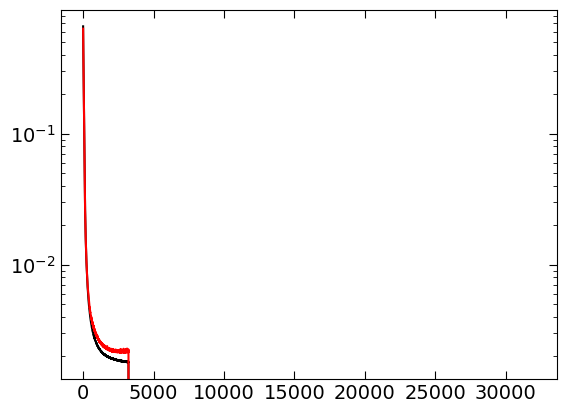

min val loss = 2.127e-03


In [401]:
plt.yscale('log')
plt.plot(nre.net.epochs,nre.net.training_loss,'k-')
plt.plot(nre.net.epochs,nre.net.val_loss,'r-')
plt.show()
min_val_loss = nre.net.val_loss[nre.net.val_loss > 0.0].min()
print('min val loss = {0:.3e}'.format(min_val_loss))

## Data

In [402]:
# theta_true = np.array([[1.0,-1.0]]).T # y = 1 - x
# data = nre.simulator(theta_true)

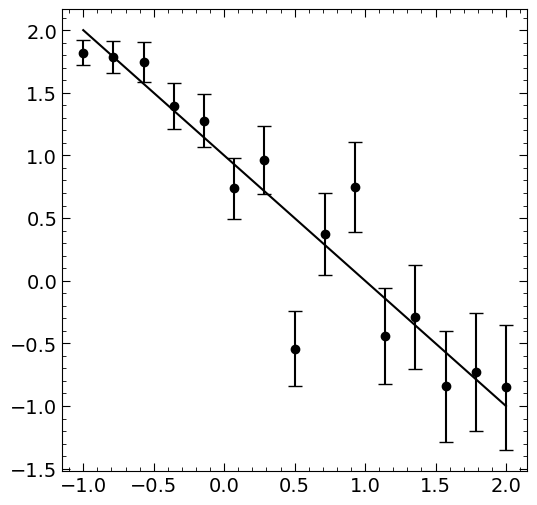

In [403]:
plt.figure(figsize=(6,6))
plt.errorbar(nre.xvals,data.T[0],yerr=nre.sigma,c='k',capsize=5,marker='o',ls='none')
plt.plot(nre.xvals,theta_true[0,0] + theta_true[1,0]*nre.xvals,'k-')
plt.minorticks_on()
plt.show()

In [404]:
theta_test = theta_true.copy()
ratio,F,theta_hat = analytical_nre(nre,data,theta_test)
Ctheta = linalg.inv(F)
print('analytical: {0:.3e}'.format(np.squeeze(ratio)))
print('predicted : {0:.3e}'.format(np.squeeze(nre.predict(data,theta_test))))

analytical: 4.168e+03
predicted : 1.397e+04


In [405]:
n_grid = 125
theta_vals = np.zeros((nparam,n_grid))
for p in range(nparam):
    theta_vals[p] = np.linspace(theta_hat[p,0]-4*np.sqrt(Ctheta[p,p]),theta_hat[p,0]+4*np.sqrt(Ctheta[p,p]),n_grid)
like_ana = np.zeros((n_grid,n_grid))
like_nre = np.zeros_like(like_ana)
mask = np.zeros((like_ana.shape[0],like_ana.shape[1]),dtype=bool)    

start_time = time()
for ix in range(n_grid):
    for iy in range(n_grid):
        theta_vec= nre.cv([theta_vals[0,ix],theta_vals[1,iy]])
        ratio_this,F_this,theta_hat_this = analytical_nre(nre,data,theta_vec)
        like_ana[ix,iy] = np.squeeze(ratio_this)
        like_nre[ix,iy] = np.squeeze(nre.predict(data,theta_vec))
        mask[ix,iy] = (np.dot((theta_vec-theta_hat).T,np.dot(F,theta_vec-theta_hat)) < 11.8)
        nre.status_bar(iy + n_grid*ix,n_grid**2)

like_ratio_ratio = like_nre/like_ana

nre.time_this(start_time)

[................... ] 100% done
0 min 2.19 seconds



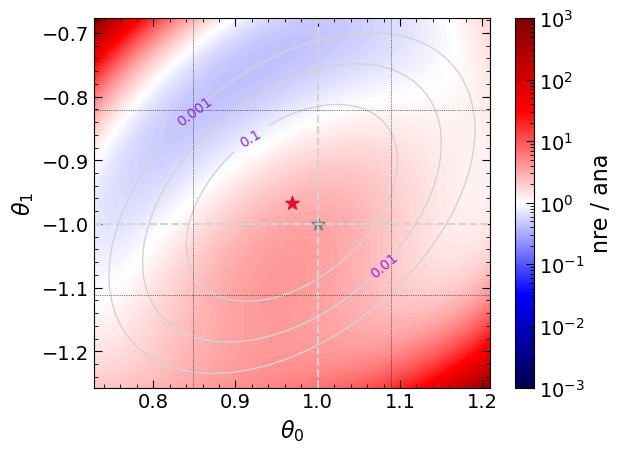

In [406]:
Vmin,Vmax = 1e-3,1e3
# convention of imshow: origin -> top left corner, x-axis pointing downward, y-axis pointing rightward
plt.xlabel("$\\theta_{{0}}$")
plt.ylabel("$\\theta_{{1}}$")
im = plt.imshow(like_ratio_ratio.T,norm=pltcol.LogNorm(vmin=Vmin,vmax=Vmax),cmap='seismic',
                origin='lower',aspect='auto',extent=[theta_vals[0].min(),theta_vals[0].max(),
                                                     theta_vals[1].min(),theta_vals[1].max()])
levels = np.sort([1e-3,0.01,0.1])
con = plt.contour(like_ana.T,levels=levels*like_ana.max(),colors='lightgray',linewidths=1,
                  origin='lower',extent=[theta_vals[0].min(),theta_vals[0].max(),
                                         theta_vals[1].min(),theta_vals[1].max()])
tobj = plt.clabel(con,colors='blueviolet')
clabs_old = []
for t in range(len(tobj)):
    clabs_old.append(tobj[t].get_text())
clabs_old = np.sort(np.unique(clabs_old).astype(float)).astype(str)
clabs = {clabs_old[l]:str(levels[l]) for l in range(len(levels))}
for t in range(len(tobj)):
    tobj[t].set(text=clabs[tobj[t].get_text()])
    
plt.scatter([theta_true[0]],[theta_true[1]],marker='*',s=100,color='gray')
plt.scatter([theta_hat[0]],[theta_hat[1]],marker='*',s=100,color='crimson')
# plt.scatter([theta_vals[0].max()],[theta_vals[1].min()],marker='*',s=200,color='k')
plt.axvline(theta_true[0],c='lightgray',lw=1.5,ls='--')
plt.axhline(theta_true[1],c='lightgray',lw=1.5,ls='--')

plt.axvline(theta_hat[0,0]-2*np.sqrt(Ctheta[0,0]),c='k',lw=0.5,ls=':')
plt.axvline(theta_hat[0,0]+2*np.sqrt(Ctheta[0,0]),c='k',lw=0.5,ls=':')
plt.axhline(theta_hat[1,0]-2*np.sqrt(Ctheta[1,1]),c='k',lw=0.5,ls=':')
plt.axhline(theta_hat[1,0]+2*np.sqrt(Ctheta[1,1]),c='k',lw=0.5,ls=':')

plt.colorbar(im,label='nre / ana')
plt.minorticks_on()
plt.show()

In [407]:
Ctheta[0,1]/np.sqrt(Ctheta[0,0]*Ctheta[1,1]),like_ratio_ratio[mask].min()/like_ratio_ratio[mask].max()

(0.42860921922969747, 0.10948542017250643)

## Network architecture comparison
#### Ideas from DSJC discussion 30 Mar 2025:
    1. Quality factor: use true MCMC chain rather than grid; then no need for analytical result
    2. Does convergence of KL divergence between MCMCs from architectures of increasing complexity help as a stopping criterion? 
    3. Repeat for low-dimensional non-linear (maybe non-Gaussian) problem

In [588]:
# raise Exception # uncomment while training to avoid accidental over-writing

print('NRE for setup...')
with open(File_Stem + '/params.pkl', 'rb') as f:
    params = pickle.load(f)  
nre_setup = MyNRE(params=params)
nre_setup.load()
print('... setup complete\n')

N_data_repeat = 25 #// 5
N_theta_repeat = 10 #// 5

n_grid = 125

Fresh_Start = True

archfile = File_Stem + '/archs.pkl'
if Fresh_Start:
    N_archs_old = 0
    archs = {}
    archs[0] = {'N1':'10','N2':'20','N3':'0','Ns_str':'1k'}
    archs[1] = {'N1':'10','N2':'20','N3':'0','Ns_str':'4k'}
    archs[2] = {'N1':'25','N2':'50','N3':'0','Ns_str':'4k'} 
    archs[3] = {'N1':'25','N2':'50','N3':'0','Ns_str':'8k'}
    archs[4] = {'N1':'50','N2':'25','N3':'0','Ns_str':'8k'}
    archs[5] = {'N1':'25','N2':'50','N3':'0','Ns_str':'80k'}
    archs[6] = {'N1':'50','N2':'100','N3':'0','Ns_str':'80k'} 
    archs[7] = {'N1':'50','N2':'100','N3':'0','Ns_str':'160k'}
    archs[8] = {'N1':'100','N2':'50','N3':'0','Ns_str':'160k'} 
    archs[9] = {'N1':'50','N2':'100','N3':'0','Ns_str':'320k'} 
    archs[10] = {'N1':'50','N2':'100','N3':'10','Ns_str':'320k'} # --> prev 17 
    archs[11] = {'N1':'50','N2':'100','N3':'20','Ns_str':'640k'} # --> prev 18
    archs[12] = {'N1':'100','N2':'100','N3':'0','Ns_str':'160k'} 
    archs[13] = {'N1':'100','N2':'100','N3':'0','Ns_str':'320k'}
    archs[14] = {'N1':'100','N2':'200','N3':'0','Ns_str':'160k'} 
    archs[15] = {'N1':'100','N2':'200','N3':'0','Ns_str':'320k'}
    # ----------------------------------------------------------
    # below only for line, not line-tight
    # ----------------------------------------------------------
    # archs[16] = {'N1':'100','N2':'200','N3':'0','Ns_str':'640k'} # --> prev 14
    # archs[17] = {'N1':'200','N2':'200','N3':'0','Ns_str':'160k'} 
    # archs[18] = {'N1':'200','N2':'200','N3':'0','Ns_str':'320k'} # --> needs retraining for line
else:
    print('Reading architecture data from:',archfile)
    with open(archfile, 'rb') as f:
        archs = pickle.load(f)  
    N_archs_old = np.max(list(archs.keys())) + 1
    # archs[N_archs_old] = {'N1':'50','N2':'100','N3':'20','Ns_str':'640k'} 

N_archs = np.max(list(archs.keys())) + 1
backup_dir = File_Stem+'/backup/shallow/'

start_time = time()

Nsim = N_theta_repeat*N_data_repeat

like_ana = np.zeros((Nsim,n_grid,n_grid))
mask = np.zeros((Nsim,n_grid,n_grid),dtype=bool)    
data_test = np.zeros((Nsim,ndata,1))
theta_test = np.zeros((Nsim,nparam,1))
theta_vals = np.zeros((Nsim,nparam,n_grid))

print('Storing analytical post-prior ratio...')
cnt = 0
for t in range(N_theta_repeat):
    theta_test_this = theta_true.copy() # nre_setup.prior(1)
    for d in range(N_data_repeat):
        data_test_this = nre_setup.simulator(theta_test_this)
        ratio,F,theta_hat = analytical_nre(nre_setup,data_test_this,theta_test_this)
        Ctheta = linalg.inv(F)
        theta_test[cnt] = theta_test_this
        data_test[cnt] = data_test_this

        for p in range(nparam):
            theta_vals[cnt,p] = np.linspace(theta_hat[p,0]-4*np.sqrt(Ctheta[p,p]),theta_hat[p,0]+4*np.sqrt(Ctheta[p,p]),n_grid)

        for ix in range(n_grid):
            for iy in range(n_grid):
                theta_vec= nre.cv([theta_vals[cnt,0,ix],theta_vals[cnt,1,iy]])
                ratio_this,F_this,theta_hat_this = analytical_nre(nre_setup,data_test_this,theta_vec)
                like_ana[cnt,ix,iy] = np.squeeze(ratio_this)
                # below is for 2-param, 3-sigma: delta chi2 = 11.8
                mask[cnt,ix,iy] = (np.dot((theta_vec-theta_hat).T,np.dot(F,theta_vec-theta_hat)) < 11.8) 
                # nre_setup.status_bar(iy + n_grid*ix,n_grid**2)
        nre_setup.status_bar(cnt,Nsim)
        cnt += 1

print('')

for a in range(N_archs_old,N_archs):
    N1 = archs[a]['N1']
    N2 = archs[a]['N2']
    N3 = archs[a]['N3']
    archs[a]['arch_size'] = int(N1) + int(N2) + int(N3)
    Ns = archs[a]['Ns_str']
    archs[a]['Ns'] = int(Ns[:-1])*1000
    complexity = int(Ns[:-1])*archs[a]['arch_size']
    archs[a]['complexity'] = complexity
    net_dir = '1tanh'+N1+'n_1tanh'+N2
    if int(N3) > 0:
        net_dir += 'n_1tanh'+N3
    net_dir += 'n_train'+Ns+'/'
    print('Architecture:'+net_dir+' ...')
    files = [f for f in Path().glob(backup_dir+net_dir+'*.*')]
    for f in files:
        shutil.copy(f,File_Stem)

    with open(File_Stem + '/params.pkl', 'rb') as f:
        params = pickle.load(f)  
    nre = MyNRE(params=params)
    nre.load()
    params_train = nre.load_train()
    print('... params_train:',params_train)
    print('... calculating network freedom = N_trainingdata / N_freeparams')
    archs[a]['freedom'] = archs[a]['Ns']/nre.net.calc_N_freeparams()
    print('... loading loss history')
    archs[a]['history'] = nre.net.load_loss_history()
    print('... recording minimum validation loss')
    valloss = archs[a]['history']['val_loss']
    archs[a]['MVL'] = valloss[valloss > 0.0].min()

    QF_all = np.zeros(Nsim)
    cnt = 0
    for t in range(N_theta_repeat):
        for d in range(N_data_repeat):
            # print('... calculating predicted post-prior ratio')
            like_nre = np.zeros((n_grid,n_grid))
            for ix in range(n_grid):
                for iy in range(n_grid):
                    theta_vec = nre.cv([theta_vals[cnt,0,ix],theta_vals[cnt,1,iy]])
                    like_nre[ix,iy] = np.squeeze(nre.predict(data_test[cnt],theta_vec))
                    # nre.status_bar(iy + n_grid*ix,n_grid**2)
            
            # print('... recording quality factor')
            like_ratio_ratio = like_nre/like_ana[cnt]
            QF = like_ratio_ratio[mask[cnt]].min()/like_ratio_ratio[mask[cnt]].max()
            QF_all[cnt] = QF
            nre.status_bar(cnt,Nsim)
            cnt += 1
    
    # below outside data/theta loop
    QFmed = np.median(QF_all)
    archs[a]['QF'] = QFmed # QF_all.mean()
    archs[a]['QFstd'] = QF_all.std()
    archs[a]['QFlo'] = QFmed - np.percentile(QF_all,16) 
    archs[a]['QFhi'] = np.percentile(QF_all,84) - QFmed
    
    print('... done\n')

print('Storing architecture data to:',archfile)
with open(archfile, 'wb') as f:
    pickle.dump(archs,f)  
nre.time_this(start_time)

NRE for setup...
... setting up 3 layer feed-forward neural network
... ... expecting data dim = 17, target dim = 1
... ... using hidden layers of sizes [100,200]
... ... ... and activations [tanh,tanh]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
... setup complete

Storing analytical post-prior ratio...
[....................] 100% done

Architecture:1tanh10n_1tanh20n_train1k/ ...
... setting up 3 layer feed-forward neural network
... ... expecting data dim = 17, target dim = 1
... ... using hidden layers of sizes [10,20]
... ... ... and activations [tanh,tanh]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
... params_train: {'max_epoch': 32000, 'lrate': 3e-05, 'check_after': 

Loading architecture data from: line-tight/archs.pkl
Writing to file: line-tight/plots/archs.png
[matplotlib.mathtext] Substituting symbol L from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol Q from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol C from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol F from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol L from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol Q from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol C from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol F from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol L from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol Q from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol C from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol F from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol L from STIXNonUnicode
[matplotlib.mathtext] Substituting symbol Q from STIXNonUnicode
[matplo

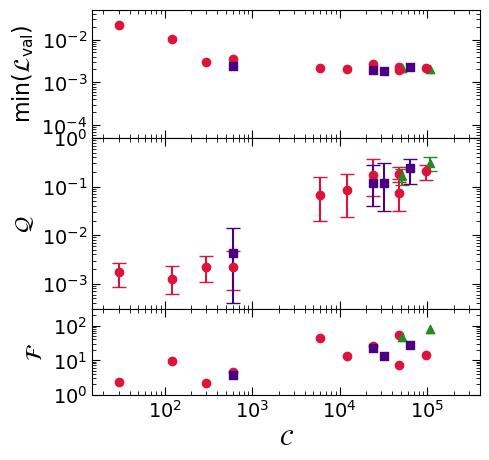

In [590]:
Save_Fig = True

# File_Stem = 'line-tight'
# Plots_Dir = File_Stem + '/plots/'
archfile = File_Stem + '/archs.pkl'
print('Loading architecture data from:',archfile)
with open(archfile, 'rb') as f:
    archs = pickle.load(f)  

N_archs = len(list(archs.keys()))

plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(3,1,height_ratios=[1.5,2,1],hspace=0)

ax = []
Xmin = 0.5*np.min([archs[n]['complexity'] for n in range(N_archs)])
Xmax = 4e5 #2.0*np.max([archs[n]['complexity'] for n in range(N_archs)])
for i in range(3):
    ax_this = plt.subplot(gs[i])
    ax_this.set_xscale('log')
    ax_this.set_yscale('log')
    ax_this.set_xlim(Xmin,Xmax)
    if i < 2:
        ax_this.set_xticklabels('')
        if i == 0:
            ax_this.set_ylim(5e-5,5e-2)
            ax_this.set_ylabel("min($\\mathcal{{L}}_{{\\rm val}}$)")
        else:
            ax_this.set_ylim(3e-4,1)
            ax_this.set_ylabel("$\\mathcal{{Q}}$")
    else:
        ax_this.set_xlabel('$\\mathcal{{C}}$') 
        ax_this.set_ylabel('$\\mathcal{{F}}$')
        ax_this.set_ylim(1,3e2)
    ax_this.minorticks_on()
    ax.append(ax_this)
        
for a in range(N_archs):
    if int(archs[a]['N3']) == 0:
        marker = 'o' if int(archs[a]['N1']) < int(archs[a]['N2']) else 's'
        color = 'crimson' if int(archs[a]['N1']) < int(archs[a]['N2']) else 'indigo'
    else:
        marker = '^'
        color = 'forestgreen'
    ax[0].scatter([archs[a]['complexity']],[archs[a]['MVL']],marker=marker,c=color)
    ax[1].errorbar([archs[a]['complexity']],[archs[a]['QF']],yerr=[[archs[a]['QFlo']],[archs[a]['QFhi']]],
                   marker=marker,c=color,capsize=5)
    ax[2].scatter([archs[a]['complexity']],[archs[a]['freedom']],marker=marker,c=color)

if Save_Fig:
    filename = 'archs.png'
    print('Writing to file: '+Plots_Dir+filename)
    plt.savefig(Plots_Dir+filename,bbox_inches='tight')
else:
    plt.show()

## MCMC

In [582]:
NRE_Id = 18 # best 11,16 for line and 9,10,11,15 for line-tight
First_Use = False

backup_dir = File_Stem+'/backup/shallow/'

archfile = File_Stem + '/archs.pkl'
print('Loading architecture data from:',archfile)
with open(archfile, 'rb') as f:
    archs = pickle.load(f)  
    
N1 = archs[NRE_Id]['N1']
N2 = archs[NRE_Id]['N2']
N3 = archs[NRE_Id]['N3']
Ns = archs[NRE_Id]['Ns_str']
complexity = archs[NRE_Id]['complexity']
freedom = archs[NRE_Id]['freedom']

net_dir = '1tanh'+N1+'n_1tanh'+N2
if int(N3) > 0:
    net_dir += 'n_1tanh'+N3 
net_dir += 'n_train'+Ns+'/'

print('Architecture:'+net_dir+' ...')
files = [f for f in Path().glob(backup_dir+net_dir+'*.*')]
for f in files:
    shutil.copy(f,File_Stem)
with open(File_Stem + '/params.pkl', 'rb') as f:
    params = pickle.load(f)  

nre = MyNRE(params=params)
nre.load()
params_train = nre.load_train()
print('... params_train:',params_train)


theta_true = nre.cv([1.0,-1.0]) # y = 1 - x
data_file = File_Stem + '/data.txt'
if First_Use:
    data = nre.simulator(theta_true)
    np.savetxt(data_file,data[:,0],fmt='%.6e')
else:
    data = np.loadtxt(data_file)
    data = nre.cv(data)

Like_Dir = '../code/likes/'

Run_MCMC = False
Run_NRE = True

Max_Samples = 1000000
Rminus1_Stop = 0.005
Rminus1_CL_Stop = 0.025 # 0.05
Rminus1_CL_Level = 0.95 # 95

Burn_In = 0

Latex_List = ['a_{0}','a_{1}']
Params_List = ['a0','a1']

info = {}
info['params'] = {}
info['likelihood'] = {'likelihoods.Chi2Like':
                      {'python_path':Like_Dir,
                       'X':nre.rv(nre.xvals),'Y':data.T,'cov_mat':nre.cov_mat}}
info['theory'] = {'examplelikes.LineTheory':
                  {'python_path':Like_Dir,
                   'X':nre.rv(nre.xvals)}}
for p in range(len(Params_List)):
    ref = 1.0
    info['params'][Params_List[p]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
                                      'prior':{'dist':'norm','loc':nre.prior_mean[p],'scale':nre.prior_std[p]},
                                      'proposal':0.01,'latex':Latex_List[p]}

info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 1000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}
info_output = File_Stem + '/stats/chains/'
info['output'] = info_output + 'mcmc'
info["force"] = True    

info_nre = copy.deepcopy(info)
info_nre['likelihood'] = {'likelihoods.NRELike':
                         {'python_path':Like_Dir}}
info_nre['theory'] = {'likelihoods.NRETheory':
                         {'python_path':Like_Dir,
                          'nre':nre,'data':data,'keys':Params_List}}
info_nre['output'] = info_output+'nre{0:d}'.format(NRE_Id)

Loading architecture data from: line/archs.pkl
Architecture:1tanh200n_1tanh200n_train320k/ ...
... setting up 3 layer feed-forward neural network
... ... expecting data dim = 17, target dim = 1
... ... using hidden layers of sizes [200,200]
... ... ... and activations [tanh,tanh]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
... params_train: {'max_epoch': 16000, 'lrate': 3e-05, 'check_after': 1000, 'mb_count': 505, 'val_frac': 0.2}


In [583]:
if Run_MCMC:
    start_time = time()
    updated_info, sampler = run(info)
    nre.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

Chains (hopefully) exist!


In [584]:
if Run_NRE:
    start_time = time()
    updated_info_nre, sampler_nre = run(info_nre)
    nre.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

[output] Output to be read-from/written-into folder 'line/stats/chains', with prefix 'nre18'
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: a0:1.000999, a1:1.000728
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {likelihoods.NRELike: 178000.0, likelihoods.NRETheory: 3730.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-04-01 10:30:57 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.842
[mcmc]  - Convergence of means: R-1 = 16.835181 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.663
[mcmc]  - Convergence of means: R-1 = 29.088210 after 128 accepted steps
[mcmc]  - Updated covarian

In [585]:
Save_Fig = True

Show_MCMC = True
Show_NRE = True

MCMC...
... best fit ( a0,...a1) = ( 1.0586e+00,-9.0916e-01 )
... std dev  ( a0,...a1) = ( 6.1268e-02,7.2682e-02 )
... chi2_best,dof,chi2_red,pval: 14.686,13,1.130,4.210e-01
NN...
... best fit ( a0,...a1) = ( 1.0567e+00,-9.2365e-01 )
... std dev  ( a0,...a1) = ( 1.1609e-01,1.2619e-01 )
... chi2_best,dof,chi2_red,pval: -19.188,13,-1.476,nan
Writing to file: line/plots/contours_line_nre18.png
0 min 0.44 seconds



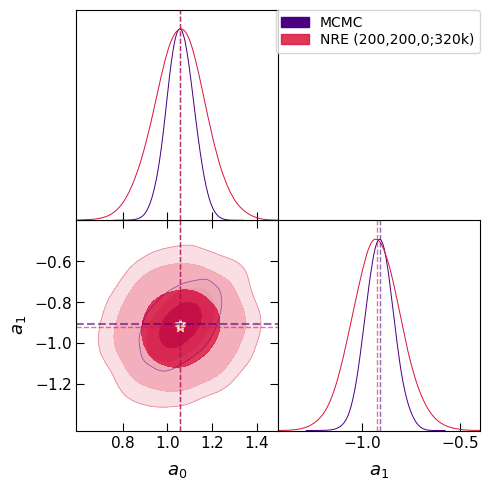

In [586]:
Burn_Frac = 0.3
rng = np.random.RandomState(42)
n_params = len(nre.prior_mean)
dim = 1*n_params
dof = ndata - n_params

start_time = time()

if Show_MCMC:
    gd_sample = loadMCSamples(str(Path(info["output"]).resolve()),settings={'ignore_rows':Burn_Frac})
    gd_sample.label = 'MCMC' 
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    sample = gd_sample.samples
    sample = sample.T
    ibest = sample[-2].argmin()
    mcmc_best = sample[:dim,ibest]
    mcmc_chi2 = sample[-2,ibest]
    pval = sysp.gammainc(mcmc_chi2/2,dof/2)
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    print('MCMC...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2,dof,mcmc_chi2/dof,pval))

if Show_NRE:
    gd_sample_nre = loadMCSamples(str(Path(info_nre["output"]).resolve()),settings={'ignore_rows':Burn_Frac})
    gd_sample_nre.label = 'NRE ({0:s},{1:s},{2:s};{3:s})'.format(archs[NRE_Id]['N1'],archs[NRE_Id]['N2'],
                                                                 archs[NRE_Id]['N3'],archs[NRE_Id]['Ns_str'])
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_nre = gd_sample_nre.getCovMat().matrix[:dim, :dim]
    sample_nre = gd_sample_nre.samples
    sample_nre = sample_nre.T
    iNRE_Id = sample_nre[-2].argmin()
    mcmc_NRE_Id = sample_nre[:dim,iNRE_Id]
    mcmc_chi2_nre = sample_nre[-2,iNRE_Id]
    pval_nre = sysp.gammainc(mcmc_chi2_nre/2,dof/2)
    mcmc_sig_nre = np.sqrt(np.diag(mcmc_covmat_nre))
    print('NN...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_NRE_Id])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_nre])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_nre,dof,mcmc_chi2_nre/dof,pval_nre))

plot_param_list = Params_List
Subplot_Size = 2.5

gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
gdplot.settings.num_plot_contours = 3
gdplot.settings.axes_fontsize = FS3
gdplot.settings.axes_labelsize = FS2
gdplot.settings.title_limit_fontsize = FS3

show_list = []
fill_list = []
col_list = []
if Show_MCMC:
    show_list.append(gd_sample)
    fill_list.append(True)
    col_list.append('indigo')
if Show_NRE:
    show_list.append(gd_sample_nre)
    fill_list.append(True)
    col_list.append('crimson')
gdplot.triangle_plot(show_list, plot_param_list,filled=fill_list,
                     contour_colors=col_list,legend_loc='upper right',
                     title_limit=0)
for par_y in range(dim):
    str_y = plot_param_list[par_y]
    ax = gdplot.subplots[par_y,par_y]
    if Show_MCMC:
        ax.axvline(mcmc_best[par_y],c='indigo',ls='--',lw=1,alpha=0.6)
    if Show_NRE:
        ax.axvline(mcmc_NRE_Id[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
    for par_x in range(par_y):
        str_x = plot_param_list[par_x]
        ax = gdplot.subplots[par_y,par_x]
        if Show_MCMC:
            ax.scatter([mcmc_best[par_x]],[mcmc_best[par_y]],marker='*',s=50,c='aliceblue')
            ax.axvline(mcmc_best[par_x],c='indigo',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best[par_y],c='indigo',ls='--',lw=1.5,alpha=0.6)
        if Show_NRE:
            ax.scatter([mcmc_NRE_Id[par_x]],[mcmc_NRE_Id[par_y]],marker='*',s=50,c='peachpuff')
            ax.axvline(mcmc_NRE_Id[par_x],c='crimson',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_NRE_Id[par_y],c='crimson',ls='--',lw=1,alpha=0.6)

if Save_Fig:
    filename = 'contours_'+File_Stem+'_nre{0:d}.png'.format(NRE_Id)
    print('Writing to file: '+Plots_Dir+filename)
    gdplot.export(fname=filename,adir=Plots_Dir)

nre.time_this(start_time)

In [ ]:
# raise Exception('Needs work')

# start_time = time()
# # MCMC
# if Show_MCMC:
#     model.params = mnt.cv(mcmc_best[:dim])
#     model_best = model.forward(mnt.X)[0]
    
#     N_Boot_Cobaya = np.min([1000,int(0.2*sample[0].size)])
#     Ind = gd_sample.random_single_samples_indices(random_state=42,max_samples=N_Boot_Cobaya)
#     N_Boot_Cobaya = Ind.size
#     print('N_Boot_Cobaya: ',N_Boot_Cobaya)
    
#     model_boot = np.zeros((N_Boot_Cobaya,n_samp),dtype=float)
    
#     print('... extracting stats from subsample')
#     for b in range(N_Boot_Cobaya):
#         params_b = sample[:dim,Ind[b]] 
#         model.params = mnt.cv(params_b[:dim])
#         model_boot[b] = model.forward(mnt.X)[0]
#         mnt.status_bar(b,N_Boot_Cobaya)
    
#     model_16pc = np.percentile(model_boot,16,axis=0)
#     model_84pc = np.percentile(model_boot,84,axis=0)

#     del model_boot
#     gc.collect()

# # NN
# if Show_NRE:
#     model.params = mnt.cv(mcmc_NRE_Id[:dim])
#     model_NRE_Id = model.forward(mnt.X)[0]
    
#     N_Boot_nre = np.min([1000,int(0.2*sample_nre[0].size)])
#     Ind_nre = gd_sample_nre.random_single_samples_indices(random_state=42,max_samples=N_Boot_nre)
#     N_Boot_nre = Ind_nre.size
#     print('N_Boot_nre: ',N_Boot_nre)
    
#     model_boot_nre = np.zeros((N_Boot_nre,n_samp),dtype=float)
    
#     print('... extracting stats from subsample')
#     for b in range(N_Boot_nre):
#         params_b = sample_nre[:dim,Ind_nre[b]] 
#         model.params = mnt.cv(params_b[:dim])
#         model_boot_nre[b] = model.forward(mnt.X)[0]
#         mnt.status_bar(b,N_Boot_nre)
    
#     model_16pc_nre = np.percentile(model_boot_nre,16,axis=0)
#     model_84pc_nre = np.percentile(model_boot_nre,84,axis=0)

#     del model_boot_nre
#     gc.collect()

# cols = ['indigo','crimson','darkgreen']
# plt.figure(figsize=(7,7))
# plt.xlabel('x')
# plt.ylabel('y')
# if Model_Type == 'ps':
#     plt.ylim(-1,6)
# else:
#     if n_comp == 1:
#         plt.ylim(-1.5,1)
#     else:
#         plt.ylim(-1.5,3)
# if Show_MCMC:
#     plt.plot(mnt.X[0],model_best,'-',lw=1,c=cols[0],label='MCMC')
#     plt.fill_between(mnt.X[0],model_84pc,model_16pc,color=cols[0],alpha=0.15)
# if Show_NRE:
#     plt.plot(mnt.X[0],model_NRE_Id,'-',lw=1,c=cols[1],label='NN')
#     plt.fill_between(mnt.X[0],model_84pc_nre,model_16pc_nre,color=cols[1],alpha=0.15)

# plt.errorbar(mnt.X[0],mnt.Y[0],yerr=sigma,c='k',ls='none',capsize=5,marker='o',markersize=4,label='data')

# plt.legend(loc='upper left')
# plt.minorticks_on()
# if Save_Fig:
#     filename = Plots_Dir+'stats_'+File_Stem+'_nre{0:d}.png'.format(NRE_Id)
#     print('Writing to file: '+filename)
#     plt.savefig(filename,bbox_inches='tight')
# plt.show()

# nre.time_this(start_time)